# PitchShiftNN Training
This is the notebook used to train the Vocal Pitch Modulator.

## Global variables/Imports
Run these cells before running either of the following sections.

In [1]:
%load_ext autoreload
%autoreload 1

import os
import csv

import scipy.io as sio
from scipy.io import wavfile
from scipy.io.wavfile import write

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import time
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss

from tqdm.notebook import trange, tqdm

from IPython.display import HTML
import warnings
from sklearn.preprocessing import OneHotEncoder

import torch
warnings.filterwarnings('ignore')
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

%aimport VPM
from VPM import *
%aimport Utils
from Utils import *
%aimport PitchShiftNN
from PitchShiftNN import *

In [2]:
# Constants that should not change without the dataset being changed
n_pitches = 16
n_vowels = 12
n_people = 3

# These dictionaries are more for reference than anything
label_to_vowel = { 0: "bed",  1: "bird",   2: "boat",  3: "book", 
                   4: "cat",  5: "dog",    6: "feet",  7: "law",  
                   8: "moo",  9: "nut",   10: "pig",  11: "say" }

vowel_to_label = { "bed": 0,  "bird": 1,  "boat":  2, "book":  3,
                   "cat": 4,  "dog":  5,  "feet":  6, "law":   7,
                   "moo": 8,  "nut":  9,  "pig":  10, "say":  11}

noteidx_to_pitch = {  0: "A2",   1: "Bb2",  2: "B2",   3: "C3",
                      4: "Db3",  5: "D3",   6: "Eb3",  7: "E3", 
                      8: "F3",   9: "Gb3", 10: "G3",  11: "Ab3",
                     12: "A3",  13: "Bb3", 14: "B3",  15: "C4" }

### Data Generation
This is copied directly from `Data Processing for Training PitchShiftNN.ipynb`.

In [3]:
# e.g. data_list[vowel_to_label["dog"]][5][1]
data_ref_list = create_data_ref_list(os.path.join("Data", 'dataset_files.csv'),
                                     n_pitches, n_vowels, n_people)

# e.g. flat_data_ref_list[flat_ref_idx(3, 1, 2)]
flat_data_ref_list = flatten_3d_array(data_ref_list, 
                                      n_vowels, n_pitches, n_people)

# Returns a flat_ref_idx, given a vowel, pitch, person
flat_ref_idx = lambda vowel, pitch, person: flat_3d_array_idx(
    vowel, pitch, person, n_vowels, n_pitches, n_people)

# Returns vowel, pitch, person, given a flat_ref_idx
nd_ref_idx = lambda idx: nd_array_idx(idx, n_vowels, n_pitches, n_people)

data_label_pairs, data_label_pairs_dict = create_data_label_pairs(n_pitches)

all_wav_data = load_wav_files(os.path.join("Data", "dataset"), 
                              flat_data_ref_list)
all_spectrograms = np.array([ stft(waveform, plot=False) for waveform in all_wav_data ])

In [4]:
# EDIT THE SHIFT AMOUNT PARAMETER HERE

shift_amt = 0
pairs = data_label_pairs_dict[shift_amt]

# X_train_base, Y_train: (_,513), (_,513)
# X_val_base, Y_val:     (_,513), (_,513)

X_train_base = []; X_val_base = []; Y_train = []; Y_val = []

for vow_idx in range(n_vowels):
    for pit_idx in range(n_pitches):
        
        # If the pair is valid, then proceed.
        if [shift_amt, pit_idx, pit_idx + shift_amt] in pairs:
        
            # Choose the person for this pitch/vowel to be used as test data.
            test_pid = int(np.random.rand() * 3)

            for pid_idx in range(n_people):
                wav_idx = flat_ref_idx(vow_idx, pit_idx, pid_idx)
                wav_idx_shifted = flat_ref_idx(vow_idx, pit_idx + shift_amt, pid_idx)

                if (pid_idx != test_pid):
                    X_train_base.extend(all_spectrograms[wav_idx].T)
                    Y_train.extend(all_spectrograms[wav_idx_shifted].T)
                else:
                    X_val_base.extend(all_spectrograms[wav_idx].T)
                    Y_val.extend(all_spectrograms[wav_idx_shifted].T)

X_train_base = np.array(X_train_base); Y_train = np.array(Y_train); X_val_base = np.array(X_val_base); Y_val = np.array(Y_val); 
                    
print(X_train_base.shape)
print(Y_train.shape)
print(X_val_base.shape)
print(Y_val.shape)

X_train_shifted = np.array([ simple_fft_pitch_shift(x, shift_amt) for x in X_train_base ])
X_val_shifted = np.array([ simple_fft_pitch_shift(x, shift_amt) for x in X_val_base ])

print(X_train_shifted.shape)
print(X_val_shifted.shape)

# X_train, X_val: (_,1026 = 513*2), (_,1026 = 513*2)

X_train = np.hstack((X_train_base,X_train_shifted))
X_val = np.hstack((X_val_base,X_val_shifted))

print(X_train.shape)
print(X_val.shape)

X_train = np.absolute(X_train)
X_val = np.absolute(X_val)
Y_train = np.absolute(Y_train)
Y_val = np.absolute(Y_val)

# Turn into PyTorch tensor format

X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))
X_train = X_train.float(); X_val = X_val.float()
Y_train = Y_train.float(); Y_val = Y_val.float()

(22272, 513)
(22272, 513)
(11136, 513)
(11136, 513)
(22272, 513)
(11136, 513)
(22272, 1026)
(11136, 1026)


### PitchShiftNN

Input: `(original window, manual pitch shifted window)`

Output: `(natural pitch shifted window)`

In [5]:
n_input = 1026; n_hid = 513; n_output = 513; 
n_epochs = 5000; lr = 0.2;

# Define model
model = PitchShiftNN(n_input = n_input, n_hid = n_hid, n_output = n_output)

# Define loss 
loss_fn = nn.MSELoss()

In [6]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

GPU Available


torch.Size([22272, 1026])


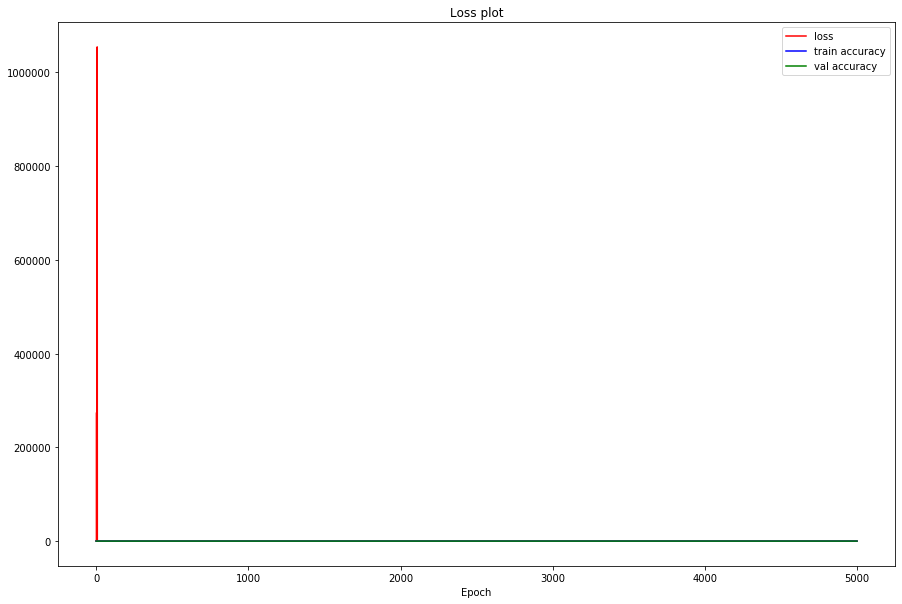

Training Loss before/after: 52.800331115722656, 52.11915588378906
Training accuracy before/after: 0, 0
Validation accuracy before/after: 0, 0
Final loss: 52.11915588378906
Time taken: 973.202544927597


In [7]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_val = X_val.to(device)
Y_val = Y_val.to(device)

# Move the network to GPU (if possible)
model.to(device) 

# Define optimizer 
opt = optim.SGD(model.parameters(), lr=lr)
# opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
loss = model.train_func(X_train, Y_train, X_val, Y_val, model, opt,
                        loss_fn, epochs=n_epochs, print_graph=True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(loss, toc - tic))

Saving the model

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "TimbreEncoder_{}_{}_{}_{}_{}_{}.pt"
                          .format(lr, n_epochs, n_mfcc, n_hid, n_timb, loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Loading the saved model, and using the model for prediction (whole dataset) example

In [ ]:
model = TimbreEncoder(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb, n_vowels=n_vowels)
model.load_state_dict(torch.load(model_path))
model.eval()
# model.to(device)

data_tensor, label_tensor = map(torch.tensor, (data, labels))
data_tensor = data_tensor.float(); label_tensor = label_tensor.long(); 
# data_tensor = data_tensor.to(device); label_tensor = label_tensor.to(device)

correct = 0; wrong = 0;
corrects = np.zeros(n_vowels); wrongs = np.zeros(n_vowels)
predictions = np.zeros((n_vowels, n_vowels));
for vowel_idx in range(n_vowels):
    for pitch_idx in range(n_pitches):
        for pid_idx in range(n_people):
            wav_idx = flat_ref_idx(vowel_idx, pitch_idx, pid_idx)
            for win_idx in range(n_windows):
                data_idx = flat_data_idx(wav_idx, win_idx)
                label = (label_tensor[data_idx]).item()
                pred = (torch.argmax(model(data_tensor[data_idx]))).item()
                
                predictions[vowel_idx][pred] = predictions[vowel_idx][pred] + 1
                if label == pred:
                    correct = correct + 1
                    corrects[vowel_idx] = corrects[vowel_idx] + 1
                else:
                    wrong = wrong + 1
                    wrongs[vowel_idx] = wrongs[vowel_idx] + 1
                    
print("Total Accuracy: {}"
      .format(correct / (wrong + correct)))
for vowel_idx in range(n_vowels):
    print("Vowel: {}. Accuracy: {}. Most common pred: {}"
          .format(label_to_vowel[vowel_idx],
                  corrects[vowel_idx] / (wrongs[vowel_idx] + corrects[vowel_idx]),
                  label_to_vowel[np.argmax(predictions[vowel_idx])]))


### Timbre-VAE - MFCC -> MFCC
This takes MFCC, reduces dimensionality to a `n_timb` latent space, and attempts to recreate the MFCC.

In [ ]:
n_hid = 10; n_timb = 4; lr = 1e-3; n_epochs = 10000; batch_size=22272

# Training model 
model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

# Define loss - from pytorch VAE example.
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [ ]:
print("GPU Available" if torch.cuda.is_available() else "GPU Not available")

In [ ]:
# Use GPU if possible (will run on CPU otherwise)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Move inputs to GPU (if possible)
X_train = X_train.to(device)
X_val = X_val.to(device)

# Move the network to GPU (if possible)
model.to(device) 
# Define optimizer 
# opt = optim.SGD(model.parameters(), lr=lr)
opt = optim.Adam(model.parameters(), lr=lr)

# Fit the model
tic = time.time()
loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                        epochs=n_epochs, print_graph = True)
toc = time.time()
print('Final loss: {}\nTime taken: {}'.format(loss, toc - tic))

Saving the model

In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
model_path = os.path.join("model_data", "TimbreVAE_{}_{}_{}_{}_{}_{}_{}.pt"
                          .format(lr, n_epochs, n_mfcc, n_hid, n_timb, batch_size, loss))
torch.save(model.state_dict(), model_path)
print("Model saved at {}".format(model_path))

Loading the saved model, and using the model for prediction example

In [ ]:
model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb, n_vowels=n_vowels)
model.load_state_dict(torch.load(model_path))
model.eval()

data_tensor = torch.tensor(data)
data_tensor = data_tensor.float();

wav_idx = flat_ref_idx(5, 5, 1)
data_idx = flat_data_idx(wav_idx, 30)
label = data_tensor[data_idx]
pred = model(data_tensor[data_idx])

## Experiment: Choosing `n_hid`, `n_timb`

From running this, we find the results:
Best `n_hid`: 10, Best `n_timb`: 4

In [23]:
# Define loss - from pytorch VAE example.
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

n_hid_candidates = [6, 8, 10, 12, 14, 16, 18]
n_timb_candidates = [4, 6, 8, 10, 12, 14, 16]
lr = 1e-3; n_epochs = 2500; batch_size=22272
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

losses = []
for hid_idx in range(len(n_hid_candidates)):
    for timb_idx in range(len(n_timb_candidates)):
        if (hid_idx < timb_idx): continue
        n_hid = n_hid_candidates[hid_idx]
        n_timb = n_timb_candidates[timb_idx]
        
        # Training model 
        model = TimbreVAE(n_mfcc=n_mfcc, n_hid=n_hid, n_timb=n_timb)

        X_train = X_train.to(device)
        X_val = X_val.to(device)
        model.to(device) 
        # opt = optim.SGD(model.parameters(), lr=lr)
        opt = optim.Adam(model.parameters(), lr=lr)

        # Fit the model
        tic = time.time()
        loss, val_loss = model.train_func(X_train, X_val, model, opt, loss_fn, batch_size=batch_size,
                                epochs=n_epochs, print_graph=False, desc="n_hid: {}, n_timb: {}".format(n_hid, n_timb))
        toc = time.time()
        print('n_hid: {}, n_timb: {}, Final val loss: {}, Time taken: {}'.format(n_hid, n_timb, val_loss, toc - tic))
        model_path = os.path.join("model_data", "TimbreVAE_n_hid_n_timb_experiment_{}_{}_{}.pt"
                                  .format(n_hid, n_timb, val_loss))
        torch.save(model.state_dict(), model_path)
        print("Model saved at {}".format(model_path)) 
        losses.append(val_loss)


n_hid: 6, n_timb: 4, Final val loss: 12.756245229436063, Time taken: 24.036638021469116
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_6_4_12.756245229436063.pt



n_hid: 8, n_timb: 4, Final val loss: 12.756556719198993, Time taken: 23.402870178222656
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_8_4_12.756556719198993.pt



n_hid: 8, n_timb: 6, Final val loss: 12.757583793552442, Time taken: 24.187214136123657
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_8_6_12.757583793552442.pt



n_hid: 10, n_timb: 4, Final val loss: 12.755354256465518, Time taken: 23.62875461578369
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_10_4_12.755354256465518.pt



n_hid: 10, n_timb: 6, Final val loss: 12.756701239224139, Time taken: 23.57104468345642
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_10_6_12.756701239224139.pt



n_hid: 10, n_timb: 8, Final val loss: 12.75628732264727, Time taken: 23.87569832801819
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_10_8_12.75628732264727.pt



n_hid: 12, n_timb: 4, Final val loss: 12.75652725395115, Time taken: 23.377437353134155
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_12_4_12.75652725395115.pt



n_hid: 12, n_timb: 6, Final val loss: 12.756516029094827, Time taken: 24.132755041122437
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_12_6_12.756516029094827.pt



n_hid: 12, n_timb: 8, Final val loss: 12.757957020025144, Time taken: 21.46918272972107
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_12_8_12.757957020025144.pt



n_hid: 12, n_timb: 10, Final val loss: 12.757127783764368, Time taken: 24.31379532814026
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_12_10_12.757127783764368.pt



n_hid: 14, n_timb: 4, Final val loss: 12.75653426948635, Time taken: 23.120083808898926
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_14_4_12.75653426948635.pt



n_hid: 14, n_timb: 6, Final val loss: 12.75579904139727, Time taken: 23.299814462661743
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_14_6_12.75579904139727.pt



n_hid: 14, n_timb: 8, Final val loss: 12.757596421515805, Time taken: 24.524491548538208
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_14_8_12.757596421515805.pt



n_hid: 14, n_timb: 10, Final val loss: 12.756250841864224, Time taken: 24.066789388656616
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_14_10_12.756250841864224.pt



n_hid: 14, n_timb: 12, Final val loss: 12.757847577676007, Time taken: 23.379464149475098
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_14_12_12.757847577676007.pt



n_hid: 16, n_timb: 4, Final val loss: 12.75629153196839, Time taken: 23.141919136047363
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_4_12.75629153196839.pt



n_hid: 16, n_timb: 6, Final val loss: 12.75677841011135, Time taken: 23.408835649490356
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_6_12.75677841011135.pt



n_hid: 16, n_timb: 8, Final val loss: 12.757703057650861, Time taken: 23.205310583114624
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_8_12.757703057650861.pt



n_hid: 16, n_timb: 10, Final val loss: 12.756217167295258, Time taken: 18.973145723342896
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_10_12.756217167295258.pt



n_hid: 16, n_timb: 12, Final val loss: 12.756746138649426, Time taken: 18.91083335876465
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_12_12.756746138649426.pt



n_hid: 16, n_timb: 14, Final val loss: 12.757397180316092, Time taken: 19.097800970077515
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_16_14_12.757397180316092.pt



n_hid: 18, n_timb: 4, Final val loss: 12.756252244971265, Time taken: 18.403200149536133
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_4_12.756252244971265.pt



n_hid: 18, n_timb: 6, Final val loss: 12.755765366828305, Time taken: 20.536202669143677
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_6_12.755765366828305.pt



n_hid: 18, n_timb: 8, Final val loss: 12.756218570402298, Time taken: 18.79640245437622
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_8_12.756218570402298.pt



n_hid: 18, n_timb: 10, Final val loss: 12.757287737966953, Time taken: 19.083486557006836
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_10_12.757287737966953.pt



n_hid: 18, n_timb: 12, Final val loss: 12.757718491828305, Time taken: 19.04806160926819
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_12_12.757718491828305.pt



n_hid: 18, n_timb: 14, Final val loss: 12.75823904454023, Time taken: 19.794686317443848
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_14_12.75823904454023.pt



n_hid: 18, n_timb: 16, Final val loss: 12.756389749461206, Time taken: 18.548084497451782
Model saved at model_data\TimbreVAE_n_hid_n_timb_experiment_18_16_12.756389749461206.pt


In [39]:
indices = [ [n_hid_candidates[hid_idx], n_timb_candidates[timb_idx]] 
            for hid_idx in range(len(n_hid_candidates))
            for timb_idx in range(len(n_timb_candidates)) if (hid_idx >= timb_idx) ]
best_hid, best_timb = indices[np.argmin(np.array(losses))]
print("Best n_hid: {}, Best n_timb: {}".format(best_hid, best_timb))
print(np.array(list(zip(losses, indices))))

Best n_hid: 10, Best n_timb: 4
[[12.756245229436063 list([6, 4])]
 [12.756556719198993 list([8, 4])]
 [12.757583793552442 list([8, 6])]
 [12.755354256465518 list([10, 4])]
 [12.756701239224139 list([10, 6])]
 [12.75628732264727 list([10, 8])]
 [12.75652725395115 list([12, 4])]
 [12.756516029094827 list([12, 6])]
 [12.757957020025144 list([12, 8])]
 [12.757127783764368 list([12, 10])]
 [12.75653426948635 list([14, 4])]
 [12.75579904139727 list([14, 6])]
 [12.757596421515805 list([14, 8])]
 [12.756250841864224 list([14, 10])]
 [12.757847577676007 list([14, 12])]
 [12.75629153196839 list([16, 4])]
 [12.75677841011135 list([16, 6])]
 [12.757703057650861 list([16, 8])]
 [12.756217167295258 list([16, 10])]
 [12.756746138649426 list([16, 12])]
 [12.757397180316092 list([16, 14])]
 [12.756252244971265 list([18, 4])]
 [12.755765366828305 list([18, 6])]
 [12.756218570402298 list([18, 8])]
 [12.757287737966953 list([18, 10])]
 [12.757718491828305 list([18, 12])]
 [12.75823904454023 list([18, 14])